<a href="https://colab.research.google.com/github/Priyanka-Police-Reddy-Gari/MultiLabelClassification_StackExchange/blob/main/Priyanka_PartB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data and Split

In [ ]:
!pip install torchinfo
!pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
from torchtext.vocab import vocab
from torchinfo import summary
from torchmetrics import HammingDistance
import tensorflow as tf

import random

import numpy as np

import joblib
from collections import Counter
from functools import partial
from pathlib import Path

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import sys
import ast

In [ ]:
basepath = '/content/drive/MyDrive/NLP'

In [ ]:
sys.path.append('/content/drive/MyDrive/NLP/data/custom-functions')

In [ ]:
basefolder = Path(basepath)
datafolder = basefolder/"Assignment_4/Data/"
modelfolder = basefolder/"Assignment_4/Model/"
customfolder = basefolder/"data/custom-functions/"

In [ ]:
multilabel_data = joblib.load(datafolder/'df_multilabel_hw_cleaned.joblib')

In [ ]:
multilabel_data

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [ ]:
#Converting labels from Object to Integer
multilabel_data["Tag_Number"] = multilabel_data["Tag_Number"].apply(ast.literal_eval)

In [ ]:
X = multilabel_data.drop(["Tags","Tag_Number"],axis=1).values.tolist()
y = multilabel_data["Tag_Number"].values
X = list(map(str,X))

In [ ]:
type(X)

list

In [ ]:
# X

In [ ]:
type(y)

numpy.ndarray

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [ ]:
print(y)

[[1 0 0 ... 0 0 1]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [ ]:
type(y)

numpy.ndarray

In [ ]:

X1_train,X1_temp,y1_train,y1_temp = train_test_split(X,y,test_size=0.4,random_state=42)


In [ ]:
X1_val,X1_test,y1_val,y1_test = train_test_split(X1_temp,y1_temp,test_size=0.5,random_state=42)

# Vectorizer

In [ ]:
X1_df = [X1_train,X1_val, X1_test]

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)

X_tfidf_vectors = [vectorizer.fit_transform(text).toarray() for text in X1_df]
X_tensors = [torch.tensor(vector, dtype=torch.float32) for vector in X_tfidf_vectors]

# X1_tfidf_train = torch.tensor(vectorizer.fit_transform(X1_train_cleaned).toarray(), dtype=torch.float32)
# X1_tfidf_val = torch.tensor(vectorizer.transform(X1_val_cleaned).toarray(), dtype=torch.float32)
# X1_tfidf_test = torch.tensor(vectorizer.transform(X1_test_cleaned).toarray(), dtype=torch.float32)
X1_tfidf_train, X1_tfidf_val, X1_tfidf_test = X_tensors
# X1_tfidf_train = vectorizer.fit_transform(X1_train_cleaned)
# X1_tfidf_val = vectorizer.transform(X1_val_cleaned)
# X1_tfidf_test =  vectorizer.transform(X1_test_cleaned)

In [ ]:
print(X1_tfidf_train.shape)
print(X1_tfidf_val.dtype)
print(X1_tfidf_val.shape)
print(X1_tfidf_test.shape)

torch.Size([28456, 5000])
torch.float32
torch.Size([9485, 5000])
torch.Size([9486, 5000])


In [ ]:
print(X1_tfidf_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
X1_tfidf_train.shape

torch.Size([28456, 5000])

# Custom Dataset class

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):

        # Storing feature data (texts)
        self.X = X

        # Storing the target labels
        self.y = y

    def __len__(self):

        return len(self.X)

    def __getitem__(self, idx):

        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (texts, labels)

        return sample


In [ ]:
y1_train = torch.tensor(y1_train, dtype = torch.float32)
y1_val = torch.tensor(y1_val, dtype = torch.float32)
y1_test = torch.tensor(y1_test, dtype = torch.float32)

In [ ]:
trainset1 = CustomDataset(X1_tfidf_train,y1_train)
validationset1 = CustomDataset(X1_tfidf_val,y1_val)
testset1 = CustomDataset(X1_tfidf_test,y1_test)

In [ ]:
trainset1[0:5]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]]))

# Step Function

In [ ]:
def step( model, inputs, targets, device, loss_function, optimizer=None, clip_value = None):
    """
    Performs a forward and backward pass for a given batch of inputs and targets.

    Parameters:
    - inputs (torch.Tensor): The input data for the model.
    - targets (torch.Tensor): The true labels for the input data.
    - model (torch.nn.Module): The neural network model.
    - device (torch.device): The computing device (CPU or GPU).
    - loss_function (torch.nn.Module, optional): The loss function to use.
    - optimizer (torch.optim.Optimizer, optional): The optimizer to update model parameters.

    Returns:
    - loss (float): The computed loss value (only if loss_function is not None).
    - outputs (torch.Tensor): The predictions from the model.
    - correct (int): The number of correctly classified samples in the batch.
    """
    # Move the model and data to the device
    # train_metric.to(device)
    # model = model.to(device)
    # inputs = inputs.to(device)

    # targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2a: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 2b: Calculate the number of correctly classified samples
    # predicted = torch.argmax(outputs.data, 1)
    # correct = (predicted == targets).sum().item()
    with torch.no_grad():
      y_pred = (outputs.data > 0.5).float()
      train_metric.update(y_pred,targets)
    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(),clip_value=CLIP_VALUE)
        optimizer.step()

    # Return relevant metrics
    if loss_function:
        return loss, outputs, train_metric
    else:
        return None, outputs, train_metric


# Train epoch

In [ ]:
def train_epoch(train_loader,model,device,loss_function,optimizer):
  model.train()
  running_train_loss = 0.0
  for inputs,targets in train_loader:
    loss,_,hammingdistance = step(model,inputs,targets,device,loss_function,optimizer)
    running_train_loss += loss.item()
    train_epoch_hammingdistance = hammingdistance.compute()
  train_loss = running_train_loss/len(train_loader)
  return train_loss,train_epoch_hammingdistance

# Val epoch

In [ ]:
def val_epoch(val_loader,model,device,loss_function):
  model.eval()
  running_val_loss = 0.0
  with torch.no_grad():
    for inputs,targets in val_loader:
      loss,_,hammingdistance = step(model,inputs,targets,device,loss_function)
      running_val_loss += loss.item()
      val_epoch_hammingdistance = hammingdistance.compute()
    val_loss = running_val_loss/len(val_loader)
  return val_loss,val_epoch_hammingdistance

# Train

In [ ]:
def train(train_loader,val_loader,model,device,loss_function,optimizer,epochs):
  train_loss_history = []
  val_loss_history = []
  train_hd_history = []
  val_hd_history = []
  for epoch in range(epochs):
    train_loss,train_hamm = train_epoch(train_loader,model,device,loss_function,optimizer)
    val_loss,val_hamm = val_epoch(val_loader,model,device,loss_function)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_hd_history.append(train_hamm)
    val_hd_history.append(val_hamm)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Hamming Distance: {train_hamm:.4f}")
    print(f"Valid Loss: {val_loss:.4f} | Valid Hamming Distance: {val_hamm:.4f}")
    print()

  return train_loss_history,val_loss_history,train_hd_history,val_hd_history


# Network

In [ ]:
class custom_nnpb(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,drop_prob1,drop_prob2,output_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(p = drop_prob1)
        self.batchnorm1 = nn.BatchNorm1d(num_features=hidden_dim1)
        self.hidden2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(p = drop_prob2)
        self.batchnorm2 = nn.BatchNorm1d(num_features=hidden_dim2)
        self.output = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):

        x = self.hidden1(x)
        x = nn.ReLU()(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.hidden2(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        x = self.output(x)

        return x

# Hyper-parameter

In [ ]:
INPUT_DIM=5000
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS = 10
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.000
CLIP_VALUE = 10

# Training Configuration

In [ ]:
# Define the loss function for the model
loss_function = torch.nn.BCEWithLogitsLoss()

In [ ]:
SEED = 254
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
train_loader = torch.utils.data.DataLoader(trainset1,batch_size=BATCH_SIZE,shuffle=False)
val_loader = torch.utils.data.DataLoader(validationset1,batch_size=BATCH_SIZE,shuffle=False)
test_loader = torch.utils.data.DataLoader(testset1,batch_size=BATCH_SIZE,shuffle=False)
model_stack_ex = custom_nnpb(input_dim=INPUT_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       output_dim=NUM_OUTPUTS)
optimizer = torch.optim.AdamW(model_stack_ex.parameters(), lr=LEARNING_RATE)
train_metric = HammingDistance(task="multilabel", num_labels=10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(len(train_loader))

223


# Sanity Check

In [ ]:
# for inputs, targets in train_loader:
#     #Move inputs and targets to the CPU.
#     inputs = inputs.to(device)
#     print(inputs)
#     print(inputs.shape)
#     targets = targets.to(device)
#     print(targets)
#     print(targets.shape)
#     model_stack_ex = model_stack_ex.to(device)
#     model_stack_ex.eval()
#     print(f'Input data type: {inputs.dtype}')
#     print(f'Target data type: {targets.dtype}')
#     with torch.no_grad():
#         output = model_stack_ex(inputs)
#         print("Output type",output.dtype)
#         print(loss_function)
#         loss = loss_function(output, targets)
#         print(f'Actual loss: {loss.item()}')
#     break

# print(f'Expected Theoretical loss: {np.log(2)}')


In [ ]:
train_losses, train_dist, valid_losses, valid_dist = train(
    train_loader, val_loader, model_stack_ex, device, loss_function, optimizer,EPOCHS
)

Epoch 1/5
Train Loss: 0.3523 | Train Hamming Distance: 0.0917
Valid Loss: 0.5158 | Valid Hamming Distance: 0.1262

Epoch 2/5
Train Loss: 0.1372 | Train Hamming Distance: 0.0936
Valid Loss: 0.5958 | Valid Hamming Distance: 0.1116

Epoch 3/5
Train Loss: 0.1093 | Train Hamming Distance: 0.0923
Valid Loss: 0.6694 | Valid Hamming Distance: 0.1047

Epoch 5/5
Train Loss: 0.0831 | Train Hamming Distance: 0.0897
Valid Loss: 0.7798 | Valid Hamming Distance: 0.0976



# Plot losses and metrics

In [ ]:
def plot_history(train_losses, train_metrics, valid_losses=None, val_metrics=None):

    # Determine the number of epochs based on the length of train_losses
    epochs = range(1, len(train_losses) + 1)

    # Plotting training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")  # Plot training losses
    if valid_losses:  # Check if validation losses are provided
        plt.plot(epochs, valid_losses, label="Validation")  # Plot validation losses
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation metrics
    if train_metrics[0] is not None:  # Check if training metrics are available
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")  # Plot training metrics
        if val_metrics:  # Check if validation metrics are provided
            plt.plot(epochs, val_metrics, label="Validation")  # Plot validation metrics
        plt.xlabel("Epochs")
        plt.ylabel("Metric-Hamming Distance")
        plt.legend()
        plt.show()
    return train_losses


In [ ]:
print(valid_losses)

[tensor(0.0917), tensor(0.0936), tensor(0.0923), tensor(0.0907), tensor(0.0897)]


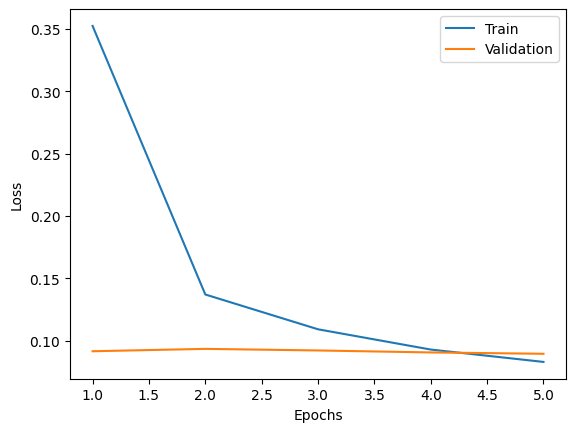

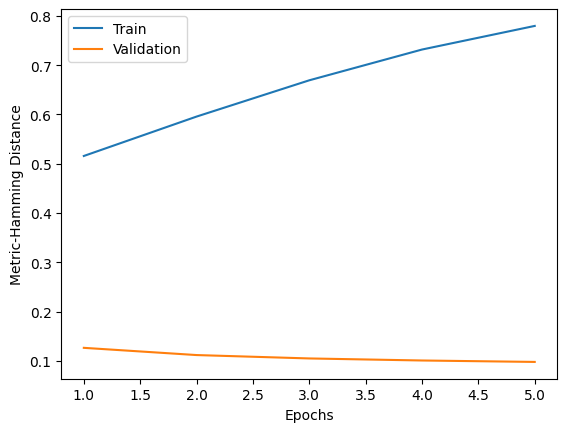

[0.3522613000442094,
 0.13715495356262533,
 0.10927950527368639,
 0.09304976239466346,
 0.0831439613527514]

In [ ]:
plot_history(train_losses, train_dist, valid_losses, valid_dist)

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
suffix = 'hw4-b'
path = modelfolder / f'{timestamp}_{suffix}.pt'
path


PosixPath('/content/drive/MyDrive/NLP/Assignment_4/Model/2024-03-05_00-24-22_hw4-b.pt')

In [ ]:
torch.save(model_stack_ex.state_dict(), path)


In [ ]:
model_stack_ex_1 = custom_nnpb(input_dim=INPUT_DIM,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       output_dim=NUM_OUTPUTS)
checkpoint = torch.load(path)
model_stack_ex_1.load_state_dict(checkpoint)


<All keys matched successfully>

In [ ]:
def get_acc_pred(data_loader, model, device):
   train_metric.to(device)
   model = model.to(device)
   model.eval()
   predictions = torch.Tensor().to(device)
   y = torch.Tensor().to(device)
  #  predictions = torch.Tensor()
  #  y = torch.Tensor()
   with torch.no_grad():
    for inputs,targets in data_loader:
      _,outputs,_ = step(model,inputs, targets,
                              device, loss_function=None, optimizer=None)
      y_pred = (outputs.data>0.5).float()
      predictions = torch.cat((predictions, y_pred))
      y = torch.cat((y, targets.to(device)))
      # y = torch.cat((y, targets))
    hammingdistance = train_metric(y_pred,targets)
    return predictions, hammingdistance, y

# Predictions

In [ ]:
pred_test, hd_test, y_test = get_acc_pred(test_loader, model_stack_ex_1, device='cpu')
pred_train, hd_train, y_train = get_acc_pred(train_loader, model_stack_ex_1, device='cpu')
pred_valid, hd_val, y_valid = get_acc_pred(val_loader, model_stack_ex_1, device='cpu')

In [ ]:
print('Test Hamming distance', hd_test)
print('Train Hamming distance', hd_train)
print('Valid Hamming distance', hd_val)


Test Hamming distance tensor(0.1786)
Train Hamming distance tensor(0.0200)
Valid Hamming distance tensor(0.2692)


# Inference

In [ ]:
model_stack_ex_1.to(device='cpu')
model_stack_ex_1.eval()
outputs = model_stack_ex_1(X1_tfidf_test)

In [ ]:
preds = torch.argmax(outputs, dim = 1)
tags = {0: 'c#', 1: 'java' , 2: 'php',3:'javascript',4:'android',5:'jquery',6:'c++',7:'python',8:'iphone',9:'asp.net'}
pred_labels = list(map(tags.get, preds.tolist()))
print(pred_labels)

['c#', 'asp.net', 'javascript', 'c#', 'javascript', 'javascript', 'php', 'javascript', 'javascript', 'java', 'javascript', 'java', 'c#', 'java', 'javascript', 'c#', 'javascript', 'android', 'javascript', 'java', 'javascript', 'jquery', 'c#', 'javascript', 'javascript', 'jquery', 'asp.net', 'java', 'jquery', 'jquery', 'java', 'javascript', 'javascript', 'javascript', 'c#', 'javascript', 'javascript', 'java', 'javascript', 'android', 'c#', 'jquery', 'javascript', 'java', 'jquery', 'javascript', 'javascript', 'c#', 'java', 'javascript', 'javascript', 'javascript', 'javascript', 'javascript', 'asp.net', 'asp.net', 'asp.net', 'javascript', 'asp.net', 'javascript', 'javascript', 'jquery', 'c#', 'javascript', 'javascript', 'javascript', 'asp.net', 'jquery', 'java', 'javascript', 'c#', 'javascript', 'c#', 'javascript', 'javascript', 'asp.net', 'javascript', 'c#', 'javascript', 'javascript', 'asp.net', 'asp.net', 'javascript', 'asp.net', 'javascript', 'jquery', 'javascript', 'javascript', 'asp.